In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_reddit.csv')
df

,label,comment,parent_comment
0,1,Hats new,Mud sounds dragged up
1,0,I think Wisconsin will have to die to Minnesot...,Well yeah Now I just need Colorado to win
2,0,Respect,That happens in realize sex that you never see...
3,0,Why would envy play counter met when they are ...,Want wait for the top tears to finally start p...
4,1,To man conservatives just dont understand libe...,The stated that the Supreme court got Seller w...
...,...,...,...
49995,0,i didn expect this after the way he started th...,ty lawton is amazing
49996,1,You forgot the,I hope he purges every department and I hope i...
49997,1,Funny I had no downtime and was the first day,Its faster no downtime
49998,0,The a power lifted the same way Michelle is a ...,The a fucking power lifted over here acting li...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           50000 non-null  int64 
 1   comment         49881 non-null  object
 2   parent_comment  49944 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.dropna(subset=['comment'], inplace=True)
df['comment'] = df['comment'].str.lower()
df['parent_comment'] = df['parent_comment'].str.lower()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49881 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           49881 non-null  int64 
 1   comment         49881 non-null  object
 2   parent_comment  49837 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


### Comment lengths

In [7]:
df['comment_length'] = df['comment'].str.len()
df['comment_length'].describe()

count    49881.000000
mean        50.736894
std         55.367127
min          1.000000
25%         24.000000
50%         42.000000
75%         68.000000
max       8999.000000
Name: comment_length, dtype: float64

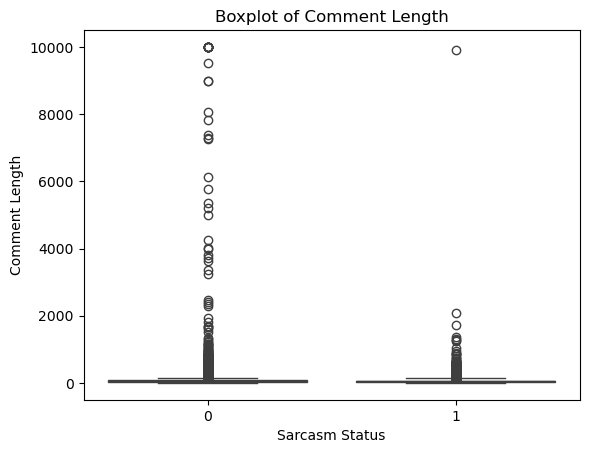

In [8]:
# boxplot of comment length
sns.boxplot(x='label', y='comment_length', data=df)
plt.xlabel('Sarcasm Status')
plt.ylabel('Comment Length')
plt.title('Boxplot of Comment Length')
plt.show()

From the quantile and boxplot of comment lengths, the majority of comment lengths are clustered within 100, with some individual very large outliers. And compared to non-sarcastic comments, sarcastic comments have fewer outliers with very long text.

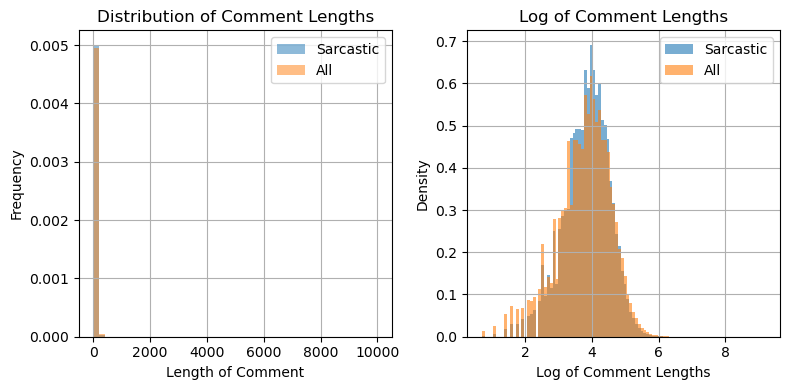

In [9]:
# Distribution of comment lengths
df['comment_length'] = df['comment'].str.len()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
df[df['label']==1]['comment_length'].plot(kind='hist', bins=50, alpha=0.5, label='Sarcastic', legend=True, density=True)
df['comment_length'].plot(kind='hist', bins=50, alpha=0.5, label='All', legend=True, density=True)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
df['log_comment'] = df1['comment'].apply(lambda text: np.log1p(len(text)))
df[df['label']==1]['log_comment'].hist(alpha=0.6,label='Sarcastic', density=True ,bins=100)
df['log_comment'].hist(alpha=0.6,label='All', density=True, bins=100)
plt.legend()
plt.xlabel('Log of Comment Lengths')
plt.ylabel('Density')
plt.title('Log of Comment Lengths')

plt.tight_layout()
plt.show()

According to the frequency distribution of comment lengths, it is evident that both sarcastic and all comments are mostly concentrated within a short length range. The majority of comments are less than 100 characters long, with very few comments exceeding this length. 

Due to the long-tail distribution, We plot a logarithmic distribution of comment lengths to get a better view of its distribution characteristics. It can be observed that the log-length distributions of both sarcastic and all comments have a similar shape, roughly following a normal distribution. Sarcastic comments tend to be slightly shorter than all comments, as indicated by the higher density of the sarcastic comments curve on the left side of the chart.

### Wordcloud of comments

Text(0.5, 1.0, 'Word Cloud for Sarcastic Comments')

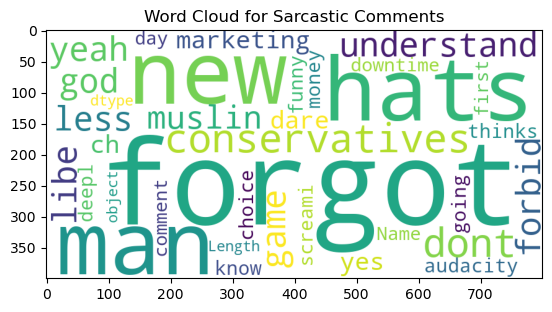

In [10]:
wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white', #max_words = 200, 
                      #max_font_size = 100, random_state = 17, 
                      width=800, height=400)

# Word cloud for sarcastic comments
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for Sarcastic Comments')

Text(0.5, 1.0, 'Word Cloud for Non-Sarcastic Comments')

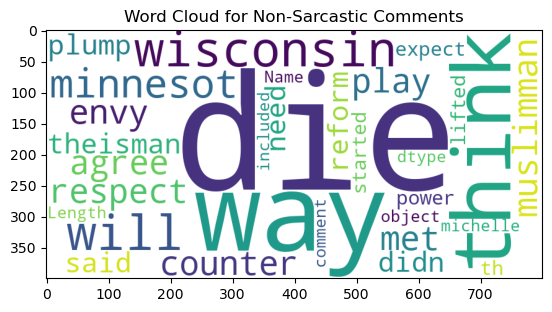

In [11]:
# Word cloud for non-sarcastic comments
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for Non-Sarcastic Comments')

Text(0.5, 1.0, 'Word Cloud for All Comments')

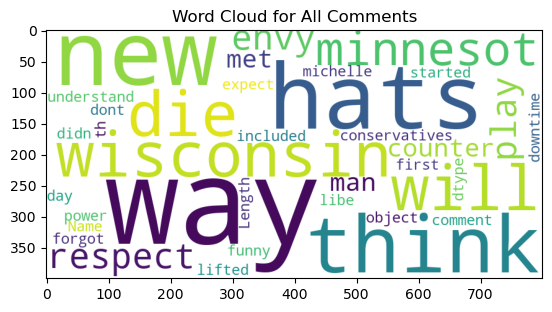

In [12]:
# Word cloud for all comments
wordcloud.generate(str(df['comment']))
plt.imshow(wordcloud)
plt.title('Word Cloud for All Comments')

### Sentiment analysis for the comments

In [13]:
# initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# calculate sentiment scores
df['comment'] = df['comment'].astype(str)
df['sentiment'] = df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

sarcastic_sentiment = df[df['label'] == 1]['sentiment']
non_sarcastic_sentiment = df[df['label'] == 0]['sentiment']

print('sarcastic_sentiment:')
print(sarcastic_sentiment.describe())
print('non_sarcastic_sentiment:')
print(non_sarcastic_sentiment.describe())

sarcastic_sentiment:
count    24987.000000
mean         0.064048
std          0.382920
min         -0.978500
25%          0.000000
50%          0.000000
75%          0.361200
max          0.982500
Name: sentiment, dtype: float64
non_sarcastic_sentiment:
count    24894.000000
mean         0.066255
std          0.358093
min         -0.970000
25%          0.000000
50%          0.000000
75%          0.340000
max          0.973200
Name: sentiment, dtype: float64


<Axes: ylabel='Frequency'>

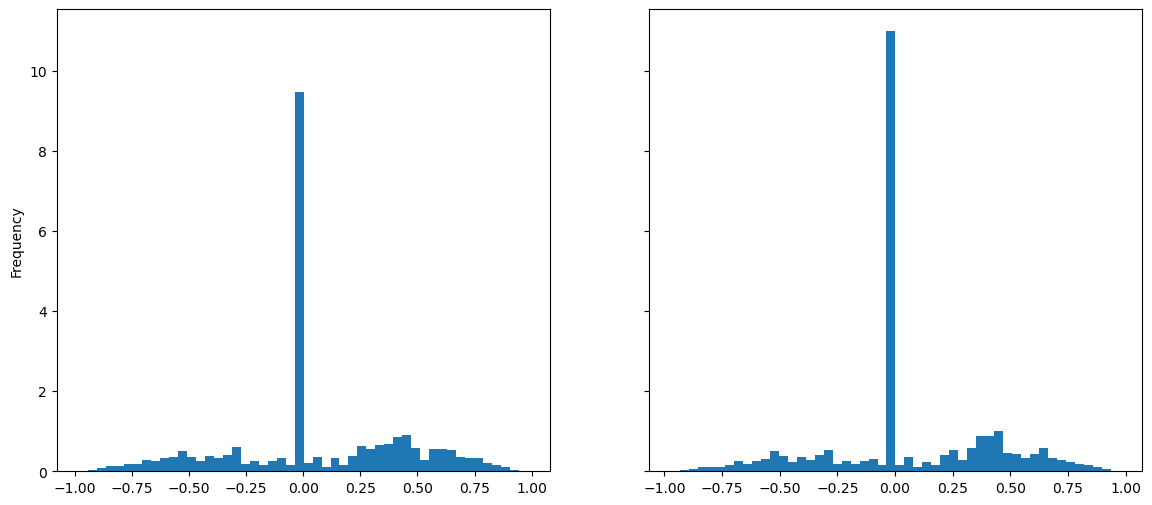

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
sarcastic_sentiment.plot(kind='hist', label='Sarcastic Comments', density=True, bins=50, ax=axes[0])
non_sarcastic_sentiment.plot(kind='hist', label='Non-Sarcastic Comments', density=True, bins=50, ax=axes[1])

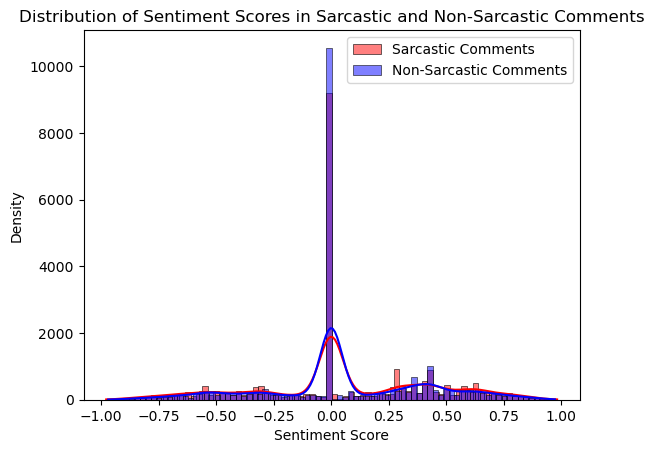

In [14]:
# Distribution of sentiment scores in sarcastic and non-sarcastic comments
sns.histplot(sarcastic_sentiment, color='red', label='Sarcastic Comments', kde=True)
sns.histplot(non_sarcastic_sentiment, color='blue', label='Non-Sarcastic Comments', kde=True)
plt.legend()
plt.title('Distribution of Sentiment Scores in Sarcastic and Non-Sarcastic Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

Sentiment scores, ranging from -1 to 1, where -1 indicates very negative sentiment and 1 indicates very positive sentiment.
 
There is a significant peak at a sentiment score of 0 for both sarcastic and non-sarcastic comments, indicating that most comments are neutral in sentiment. The overall distribution patterns of sentiment scores in sarcastic and non-sarcastic comments are quite similar, indicating that both types of comments generally cover a similar range of sentiment scores. However, there are some differences in trends, sarcastic comments are more likely to have slightly negative sentiments compared to non-sarcastic comments, which tend to have more positive sentiments.

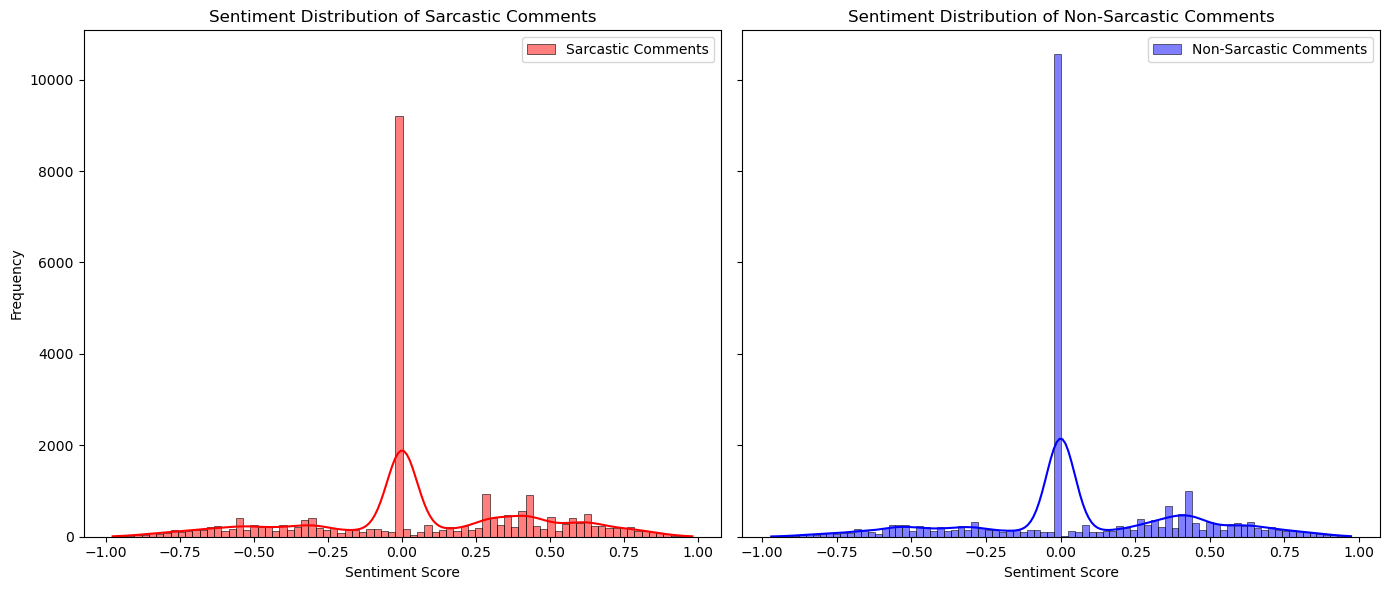

In [15]:
# Sentiment distribution of sarcastic and non-sarcastic comments
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# histplot of sarcastic comments sentiment
sns.histplot(sarcastic_sentiment, color='red', label='Sarcastic Comments', kde=True, ax=axes[0])
axes[0].set_title('Sentiment Distribution of Sarcastic Comments')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# histplot of non-sarcastic comments sentiment
sns.histplot(non_sarcastic_sentiment, color='blue', label='Non-Sarcastic Comments', kde=True, ax=axes[1])
axes[1].set_title('Sentiment Distribution of Non-Sarcastic Comments')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### Sentimental difference between comments and parent comments

In [16]:
sia = SentimentIntensityAnalyzer()

# calculate sentiment score for comment and parent comment
df['comment_sentiment'] = df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['parent_comment'] = df['parent_comment'].astype(str)
df['parent_sentiment'] = df['parent_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

# sentiment difference between comment and parent comment
df['sentiment_difference'] = df['comment_sentiment'] - df['parent_sentiment']

sarcastic_diff = df[df['label'] == 1]['sentiment_difference']
non_sarcastic_diff = df[df['label'] == 0]['sentiment_difference']

print("sentiment difference for sarcasm comments:")
print(sarcastic_diff.describe())
print("\nsentiment difference for non-sarcasm comments:")
print(non_sarcastic_diff.describe())

sentiment difference for sarcasm comments:
count    24987.000000
mean         0.025458
std          0.578396
min         -1.846100
25%         -0.371600
50%          0.000000
75%          0.421500
max          1.847800
Name: sentiment_difference, dtype: float64

sentiment difference for non-sarcasm comments:
count    24894.000000
mean        -0.011346
std          0.541000
min         -1.869200
25%         -0.381800
50%          0.000000
75%          0.361200
max          1.762000
Name: sentiment_difference, dtype: float64


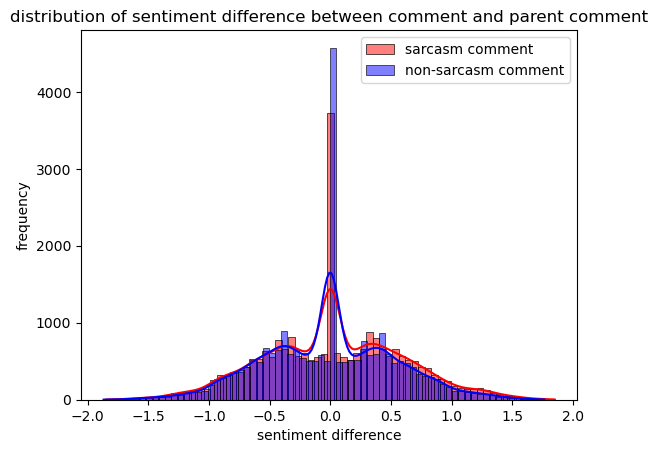

In [17]:
sns.histplot(sarcastic_diff, color='red', label='sarcasm comment', kde=True)
sns.histplot(non_sarcastic_diff, color='blue', label='non-sarcasm comment', kde=True)
plt.legend()
plt.title('distribution of sentiment difference between comment and parent comment')
plt.xlabel('sentiment difference')
plt.ylabel('frequency')
plt.show()

The x-axis represents the sentiment difference (comment sentiment - parent comment sentiment), ranging from -2 to 2.
There is a significant peak at a sentiment difference of 0, especially for non-sarcastic comments, indicating that most comments have little to no sentiment difference from their parent comments.

At the 0 sentiment difference point, non-sarcastic comments have a noticeably higher peak than sarcastic comments, suggesting that non-sarcastic comments tend to have more similar sentiments to their parent comments.  
At the sides of the sentiment difference range, sarcastic comments have a slightly higher distribution, indicating that sarcastic comments are more likely to have a different sentiment from their parent comments.

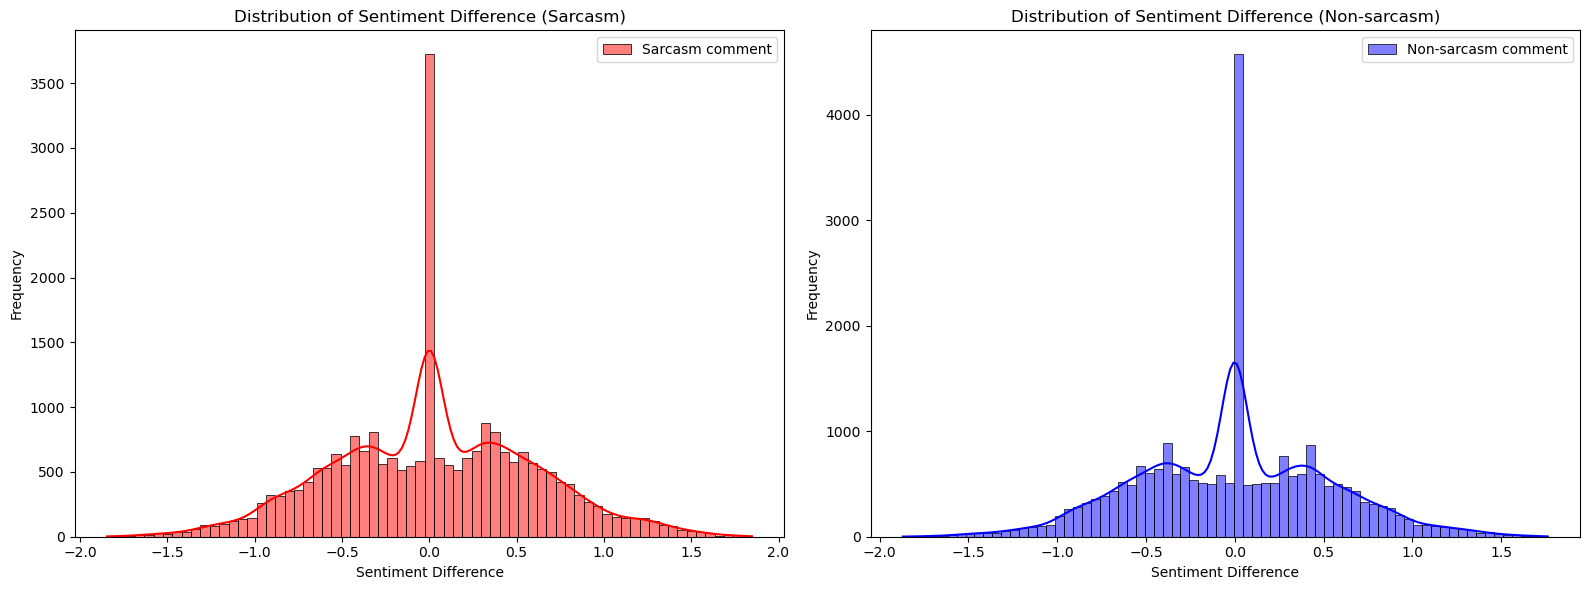

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(sarcastic_diff, color='red', label='Sarcasm comment', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Sentiment Difference (Sarcasm)')
axes[0].set_xlabel('Sentiment Difference')
axes[0].set_ylabel('Frequency')
axes[0].legend()


sns.histplot(non_sarcastic_diff, color='blue', label='Non-sarcasm comment', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Sentiment Difference (Non-sarcasm)')
axes[1].set_xlabel('Sentiment Difference')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

### Pattern analysis

In [19]:
# Preprocess the text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

In [20]:
# Preprocess the parent comments of sarcastic comments
df['parent_tokens'] = df['parent_comment'].apply(preprocess)
sarcastic_parents = df[df['label'] == 1]['parent_tokens']

n-gram

In [21]:
# Initialize n-gram counters
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

# Calculate n-gram
for tokens in sarcastic_parents:
    
    unigrams = list(ngrams(tokens, 1))
    bigrams = list(ngrams(tokens, 2))
    trigrams = list(ngrams(tokens, 3))
    
    unigram_counter.update(unigrams)
    bigram_counter.update(bigrams)
    trigram_counter.update(trigrams)

# Get the top 10 n-grams and their frequencies as a list of tuples in the format (n-gram, frequency)
sorted_word_freq_1gram = unigram_counter.most_common(10)
sorted_word_freq_2gram = bigram_counter.most_common(10)
sorted_word_freq_3gram = trigram_counter.most_common(10)

print("1-gram:", sorted_word_freq_1gram)
print("2-gram:", sorted_word_freq_2gram)
print("3-gram:", sorted_word_freq_3gram)

1-gram: [(('like',), 2681), (('people',), 2467), (('would',), 2047), (('dont',), 1876), (('one',), 1835), (('get',), 1726), (('think',), 1354), (('know',), 1220), (('time',), 1205), (('want',), 1175)]
2-gram: [(('dont', 'know'), 185), (('dont', 'think'), 156), (('feel', 'like'), 132), (('donald', 'plump'), 122), (('looks', 'like'), 111), (('dont', 'want'), 106), (('dont', 'like'), 102), (('dont', 'get'), 100), (('years', 'ago'), 89), (('anyone', 'else'), 88)]
3-gram: [(('round', 'world', 'around'), 72), (('world', 'around', 'world'), 72), (('around', 'world', 'round'), 71), (('world', 'round', 'world'), 71), (('movie', 'movie', 'movie'), 28), (('would', 'like', 'see'), 24), (('dont', 'even', 'know'), 15), (('yards', 'th', 'points'), 15), (('lot', 'caste', 'lot'), 13), (('caste', 'lot', 'caste'), 13)]


Count patterns

In [22]:
from collections import defaultdict

# Top 10 high-frequency words/n-grams as patterns
patterns = [item[0][0] for item in sorted_word_freq_1gram] + \
           [' '.join(item[0]) for item in sorted_word_freq_2gram] + \
           [' '.join(item[0]) for item in sorted_word_freq_3gram]

# Remove unwanted patterns
unwanted_patterns = {'movie movie movie', 'round world around', 'world around world', 'around world round', 'world round world', 'round world round', 'lot caste lot', 'caste lot caste', 'yards th points'}
patterns = [pattern for pattern in patterns if pattern not in unwanted_patterns]

# Initialize a dictionary to store the count for each pattern
pattern_counts = defaultdict(lambda: {'total': 0, 'sarcastic': 0})

# Calculate the total count and sarcastic count for each pattern
for _, row in df.iterrows():
    parent_text = ' '.join(row['parent_tokens']) 
    is_sarcastic = row['label'] == 1
    
    for pattern in patterns:
        if pattern in parent_text:
            pattern_counts[pattern]['total'] += 1
            if is_sarcastic:
                pattern_counts[pattern]['sarcastic'] += 1

# Calculate the sarcastic ratio for each pattern
for pattern, counts in pattern_counts.items():
    counts['sarcastic_ratio'] = counts['sarcastic'] / counts['total'] if counts['total'] > 0 else 0

print("Pattern counts:")
print(pattern_counts)

Pattern counts:
defaultdict(<function <lambda> at 0x0000021B45826E80>, {'think': {'total': 2840, 'sarcastic': 1410, 'sarcastic_ratio': 0.4964788732394366}, 'want': {'total': 2626, 'sarcastic': 1337, 'sarcastic_ratio': 0.5091393754760092}, 'would': {'total': 3337, 'sarcastic': 1640, 'sarcastic_ratio': 0.4914593946658675}, 'like': {'total': 4989, 'sarcastic': 2465, 'sarcastic_ratio': 0.4940869913810383}, 'people': {'total': 3334, 'sarcastic': 1981, 'sarcastic_ratio': 0.5941811637672465}, 'one': {'total': 8072, 'sarcastic': 4070, 'sarcastic_ratio': 0.5042120911793855}, 'know': {'total': 2605, 'sarcastic': 1301, 'sarcastic_ratio': 0.49942418426103646}, 'time': {'total': 2879, 'sarcastic': 1445, 'sarcastic_ratio': 0.5019103855505384}, 'get': {'total': 4764, 'sarcastic': 2411, 'sarcastic_ratio': 0.5060873215785054}, 'dont': {'total': 3077, 'sarcastic': 1617, 'sarcastic_ratio': 0.5255118622034449}, 'anyone else': {'total': 169, 'sarcastic': 85, 'sarcastic_ratio': 0.5029585798816568}, 'dont li

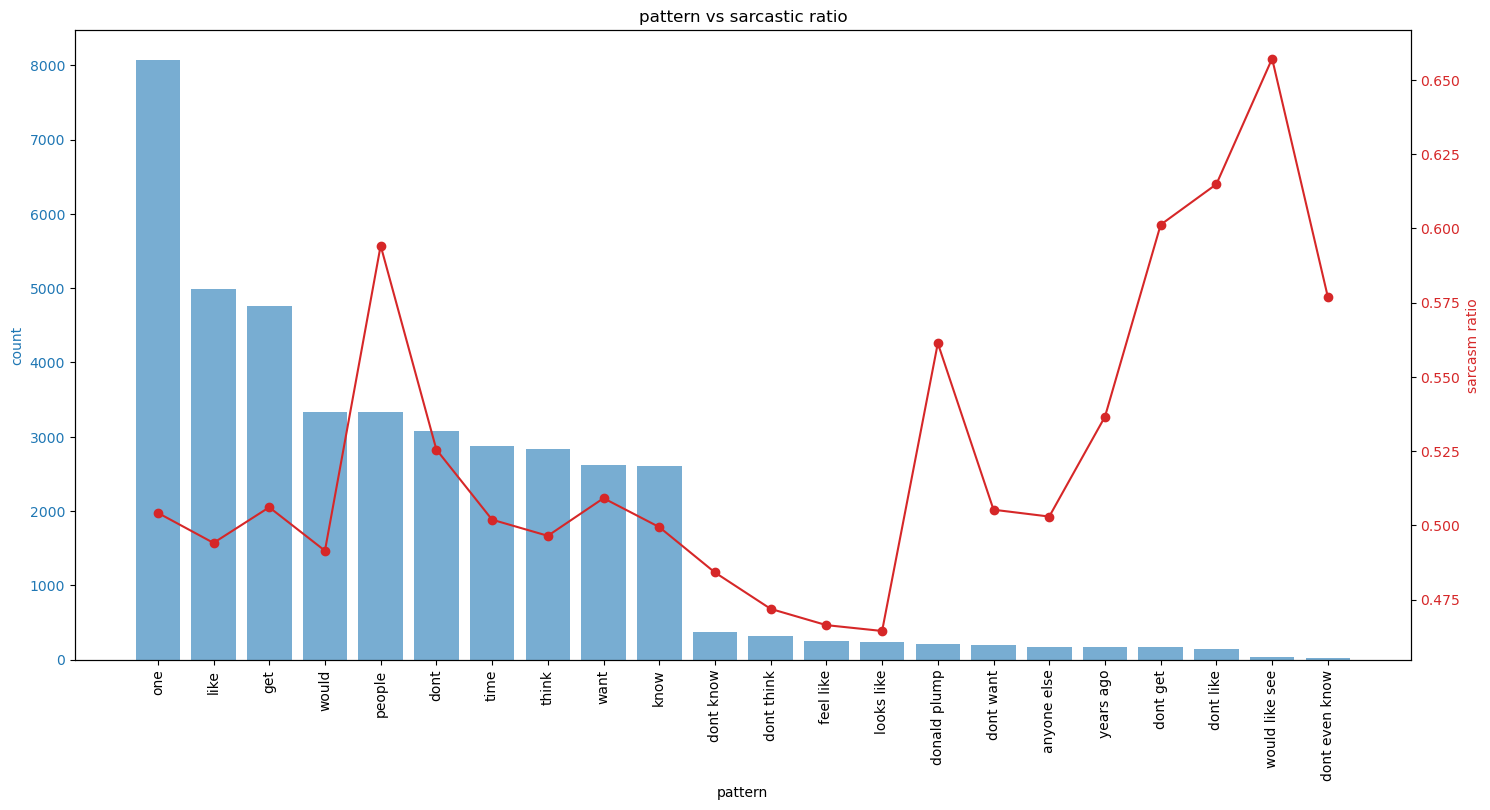

In [23]:
# Sort the pattern counts by total count
sorted_pattern_counts = sorted(pattern_counts.items(), key=lambda item: item[1]['total'], reverse=True)

patterns = [item[0] for item in sorted_pattern_counts]
total_counts = [item[1]['total'] for item in sorted_pattern_counts]
sarcastic_ratios = [item[1]['sarcastic_ratio'] for item in sorted_pattern_counts]

# Plot the total count and sarcastic ratio for each pattern
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('pattern')
ax1.set_ylabel('count', color=color)
ax1.bar(patterns, total_counts, color=color, alpha=0.6, label='total count')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=90)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('sarcasm ratio', color=color)
ax2.plot(patterns, sarcastic_ratios, color=color, marker='o', linestyle='-', label='sarcasm ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('pattern vs sarcastic ratio')
plt.show()